<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TRABAJO FINAL

**Alumna:** María Victoria Poric  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Febrero 2026 

## Introducción

A lo largo de este trabajo se buscará aplicar técnicas de análisis y procesamiento de señales vistas durante la asignatura al estudio de señales electrocardiográficas(ECG) provenientes de un contexto clínico real, utilizando el dataset "*VTaC: A Benchmark Dataset of Ventricular Alarms froms ICU Monitors*", disponible en PhysioNet. Se busca analizar y caracterizar episodios asociados a alarmas de taquicardia ventricular(VT), comparándolos con segmentos de ritmo cardíaco no patológico, con el fin de identificar diferencias relevantes en los dominios temporal y espectral, y discutir la confiabilidad de las alarmas generadas por monitores de cuidados intensivos. 

La taquicardia ventricular es una arritmia potencialmente letal cuya detección temprana resulta crítica en unidades de cuidados intensivos. Sin embargo, los sistemas de monitoreo clínico suelen generar una elevada cantidad de alarmas falsas, lo que puede derivar en fatiga del personal de salud y en una disminución de efectividad del sistema de alarmas. Es por ello que, el análisis de señales ECG mediante técnicas de procesamiento de señales permite aportar herramientas objetivas para comprender las caraterísticas de los episodios verdaderos y las causas de falsas detecciones. 

El foco de este trabajo estará puesto en la aplicación e interpretación de métodos clásicos de análisis de señales, adquiridos durante la cursada, adaptados a un nuevo contexto y a un objetivo clínico concreto. 

## Descripción del dataset

## Metodología

## Resultados

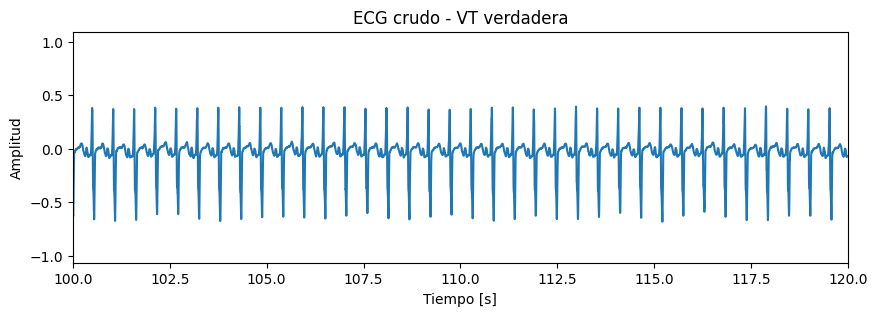

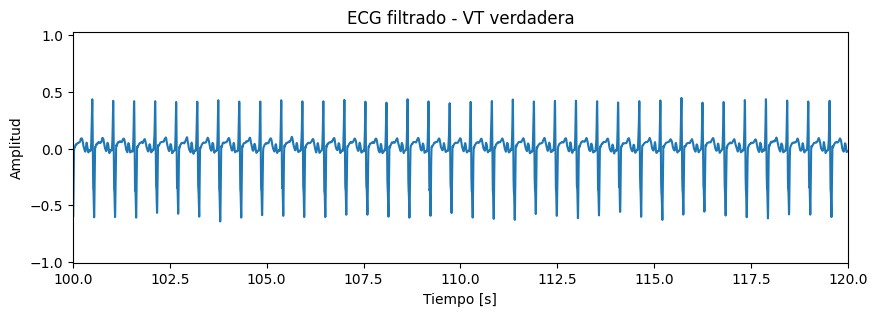

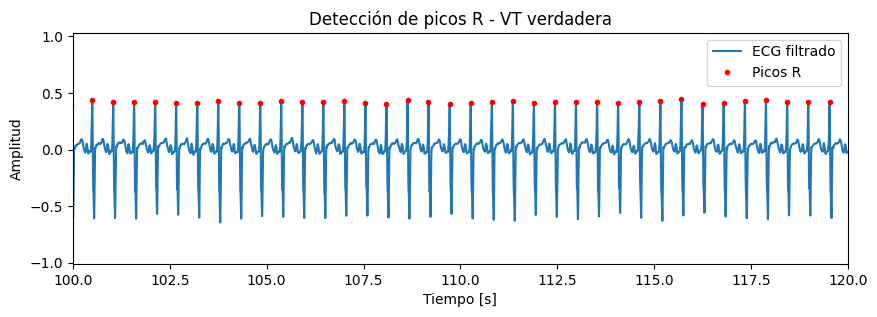

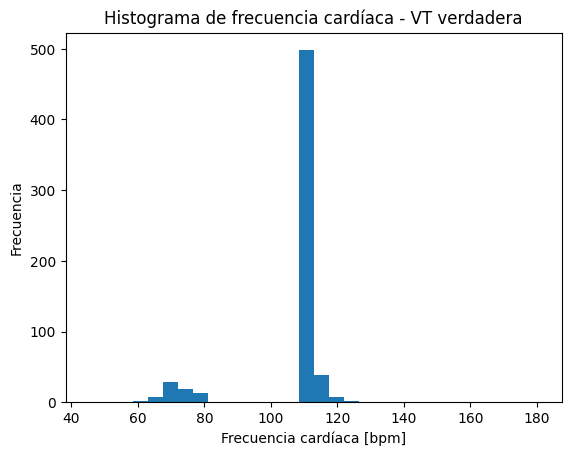

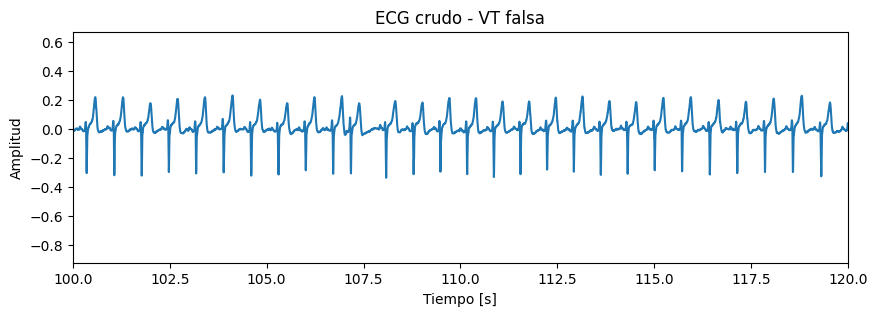

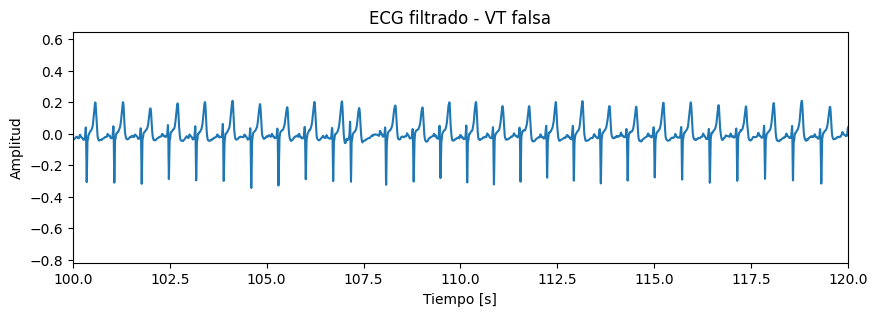

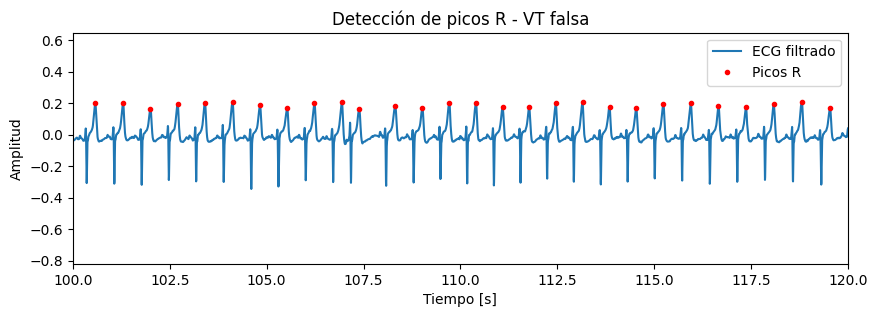

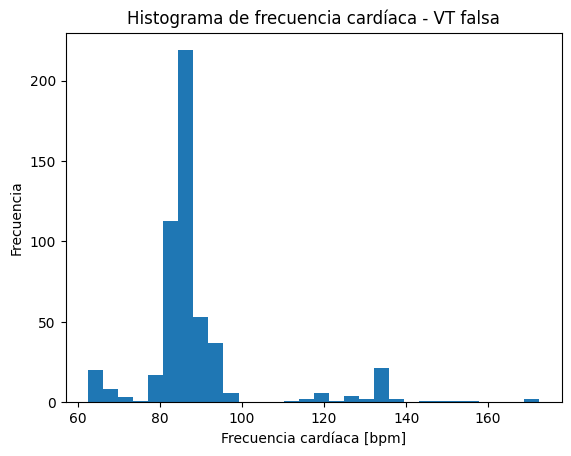

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import butter, filtfilt, find_peaks

base_path = r"C:\Users\vicky\OneDrive\Desktop\APS\vtac"
waveforms_path = os.path.join(base_path, "waveforms")
labels_path = os.path.join(base_path, "event_labels.csv")

df_labels = pd.read_csv(labels_path)

registro_true = df_labels[df_labels["decision"] == True].iloc[5]["record"]
registro_false = df_labels[df_labels["decision"] == False].iloc[14]["record"]

#---Funciones---
def encontrar_record_completo(record_id, waveforms_path):
    record_dir = os.path.join(waveforms_path, record_id)
    for f in os.listdir(record_dir):
        if f.endswith(".hea"):
            return os.path.join(record_dir, f.replace(".hea", ""))
    raise FileNotFoundError(f"No se encontró .hea en {record_dir}")

def cargar_ecg(record_id):
    record_path = encontrar_record_completo(record_id, waveforms_path)
    record = wfdb.rdrecord(record_path)
    return record.p_signal[:, 0], record.fs

def filtrar_ecg(ecg, fs, f_bajo=0.5, f_alto=40):
    b, a = butter(4, [f_bajo/(fs/2), f_alto/(fs/2)], btype='band')
    return filtfilt(b, a, ecg)

def detectar_picos_r(ecg_f, fs):
    picos, _ = find_peaks(ecg_f,
                          distance=int(0.3*fs),
                          prominence=np.std(ecg_f))
    return picos

def calcular_rr_fc(picos, fs):
    rr = np.diff(picos) / fs
    fc = 60 / rr
    return rr, fc

def analizar_y_graficar(ecg, fs, titulo):
    t = np.arange(len(ecg)) / fs
    
    #Señal cruda
    plt.figure(figsize=(10, 3))
    plt.plot(t, ecg)
    plt.title(f"ECG crudo - {titulo}")
    plt.xlim(100, 120)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.show()
    
    #Filtrado
    
    ecg_f = filtrar_ecg(ecg, fs)
    
    plt.figure(figsize=(10, 3))
    plt.plot(t, ecg_f)
    plt.title(f"ECG filtrado - {titulo}")
    plt.xlim(100, 120)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.show()
    
    #Picos R
    picos = detectar_picos_r(ecg_f, fs)
    
    plt.figure(figsize=(10, 3))
    plt.plot(t, ecg_f, label="ECG filtrado")
    plt.plot(t[picos], ecg_f[picos], 'ro', markersize=3, label="Picos R")
    plt.title(f"Detección de picos R - {titulo}")
    plt.xlim(100, 120)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()
    
    #RR y FC
    rr, fc = calcular_rr_fc(picos, fs)
    
    #Histograma FC
    plt.figure()
    plt.hist(fc, bins=30)
    plt.title(f"Histograma de frecuencia cardíaca - {titulo}")
    plt.xlabel("Frecuencia cardíaca [bpm]")
    plt.ylabel("Frecuencia")
    plt.show()
    
    return rr, fc


ecg_true, fs = cargar_ecg(registro_true)
ecg_false, _ = cargar_ecg(registro_false)

rr_true, fc_true = analizar_y_graficar(ecg_true, fs, "VT verdadera")
rr_false, fc_false = analizar_y_graficar(ecg_false, fs, "VT falsa")

## Discusión

## Conclusiones

## Referencias